# Tesla & GameStop — Stock vs Revenue Dashboard (Final Project)

*Generated on: 2025-08-24 10:05:11*

This notebook answers Questions 1–7:

1. Extract Tesla stock data using **yfinance**
2. Extract Tesla revenue data using **web scraping**
3. Extract GameStop stock data using **yfinance**
4. Extract GameStop revenue data using **web scraping**
5. Build a dashboard for **Tesla** (Price vs Revenue)
6. Build a dashboard for **GameStop** (Price vs Revenue)
7. Share the assignment notebook

**Note:** Please run this notebook with an active internet connection so data fetching and scraping can succeed.


## Setup — Imports & Helpers

In [12]:
!pip install pandas numpy matplotlib yfinance beautifulsoup4 requests


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/949.2 kB ? eta -:--:--
     ------------------------------- ------ 786.4/949.2 kB 2.9 MB/s eta 0:00:01
     ---------------------------------------- 949.2/949.2 kB 2.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (

In [13]:
import sys, warnings, re, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 120)

# Helper: safe import of yfinance
def safe_import_yfinance():
    try:
        import yfinance as yf
        return yf
    except Exception as e:
        print("yfinance is not available. Please install it with: pip install yfinance")
        raise

# Helper: check internet connectivity (simple DNS test)
def has_internet():
    try:
        import socket
        socket.gethostbyname("www.google.com")
        return True
    except Exception:
        return False

warnings.filterwarnings('ignore')
print("Environment ready.")


Environment ready.


## Question 1 — Extracting Tesla Stock Data Using yfinance (2 pts)

In [14]:
yf = safe_import_yfinance()
if not has_internet():
    raise RuntimeError("No internet connection detected. Please connect to the internet and re-run this cell.")

tsla = yf.Ticker("TSLA")
tsla_hist = tsla.history(period="max")
tsla_hist.reset_index(inplace=True)
# Keep only relevant columns
tsla_hist = tsla_hist[["Date", "Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"]]
tsla_hist.rename(columns={"Close":"Adj Close"}, inplace=True)  # In many courses 'Close' is used as adjusted close; adjust if needed

# Save and preview
tsla_hist.to_csv("TSLA_stock.csv", index=False)
print("Saved TSLA_stock.csv")
tsla_hist.head(10)


Saved TSLA_stock.csv


,Date,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
5,2010-07-07 00:00:00-04:00,1.093333,1.108667,0.998667,1.053333,103825500,0.0,0.0
6,2010-07-08 00:00:00-04:00,1.076000,1.168000,1.038000,1.164000,115671000,0.0,0.0
7,2010-07-09 00:00:00-04:00,1.172000,1.193333,1.103333,1.160000,60759000,0.0,0.0
8,2010-07-12 00:00:00-04:00,1.196667,1.204667,1.133333,1.136667,33037500,0.0,0.0
9,2010-07-13 00:00:00-04:00,1.159333,1.242667,1.126667,1.209333,40201500,0.0,0.0


## Question 2 — Extracting Tesla Revenue Data Using Web Scraping (1 pt)

In [15]:
import requests
from bs4 import BeautifulSoup

if not has_internet():
    raise RuntimeError("No internet connection detected. Please connect to the internet and re-run this cell.")

tesla_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
headers = {"User-Agent": "Mozilla/5.0"}
resp = requests.get(tesla_url, headers=headers, timeout=30)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the 'Tesla Quarterly Revenue' table by heading text proximity
tables = soup.find_all("table")
target = None
for t in tables:
    if t.find("th") and "Quarterly Revenue" in t.get_text():
        target = t
        break
if target is None:
    # fallback: look for series in script tag (Macrotrends often embeds in JS); simple fallback omitted for brevity
    raise ValueError("Could not find Tesla Quarterly Revenue table. The page structure may have changed.")

rows = []
for tr in target.find_all("tr"):
    cols = [c.get_text(strip=True) for c in tr.find_all(["td","th"])]
    if len(cols) >= 2 and re.match(r"\d{4}-\d{2}", cols[0]):
        date = cols[0]
        revenue = cols[1].replace("$","").replace(",","")
        try:
            revenue = float(revenue)  # in millions USD typically
        except:
            continue
        rows.append((date, revenue))

tsla_revenue = pd.DataFrame(rows, columns=["Date","Revenue (Millions USD)"])
tsla_revenue["Date"] = pd.to_datetime(tsla_revenue["Date"])
tsla_revenue = tsla_revenue.sort_values("Date").reset_index(drop=True)
tsla_revenue.to_csv("TSLA_revenue.csv", index=False)
print("Extracted rows:", len(tsla_revenue))
tsla_revenue.tail(10)


Extracted rows: 64


,Date,Revenue (Millions USD)
54,2023-03-31,23329.0
55,2023-06-30,24927.0
56,2023-09-30,23350.0
57,2023-12-31,25167.0
58,2024-03-31,21301.0
59,2024-06-30,25500.0
60,2024-09-30,25182.0
61,2024-12-31,25707.0
62,2025-03-31,19335.0
63,2025-06-30,22496.0


## Question 3 — Extracting GameStop Stock Data Using yfinance (2 pts)

In [16]:
yf = safe_import_yfinance()
if not has_internet():
    raise RuntimeError("No internet connection detected. Please connect to the internet and re-run this cell.")

gme = yf.Ticker("GME")
gme_hist = gme.history(period="max")
gme_hist.reset_index(inplace=True)
gme_hist = gme_hist[["Date", "Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"]]
gme_hist.rename(columns={"Close":"Adj Close"}, inplace=True)

gme_hist.to_csv("GME_stock.csv", index=False)
print("Saved GME_stock.csv")
gme_hist.head(10)


Saved GME_stock.csv


,Date,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683251,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615921,1.662210,1.603296,1.662210,6892800,0.0,0.0
5,2002-02-21 00:00:00-05:00,1.656318,1.670626,1.641169,1.658002,6976800,0.0,0.0
6,2002-02-22 00:00:00-05:00,1.670626,1.670626,1.615920,1.628545,3525600,0.0,0.0
7,2002-02-25 00:00:00-05:00,1.624337,1.653794,1.605821,1.641169,3453600,0.0,0.0
8,2002-02-26 00:00:00-05:00,1.632753,1.658002,1.606663,1.641169,2761600,0.0,0.0
9,2002-02-27 00:00:00-05:00,1.628545,1.629386,1.599088,1.611712,4091200,0.0,0.0


## Question 4 — Extracting GameStop Revenue Data Using Web Scraping (1 pt)

In [17]:
import requests
from bs4 import BeautifulSoup

if not has_internet():
    raise RuntimeError("No internet connection detected. Please connect to the internet and re-run this cell.")

gme_url = "https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue"
headers = {"User-Agent": "Mozilla/5.0"}
resp = requests.get(gme_url, headers=headers, timeout=30)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the 'GameStop Quarterly Revenue' table
tables = soup.find_all("table")
target = None
for t in tables:
    if t.find("th") and "Quarterly Revenue" in t.get_text():
        target = t
        break
if target is None:
    raise ValueError("Could not find GameStop Quarterly Revenue table. The page structure may have changed.")

rows = []
for tr in target.find_all("tr"):
    cols = [c.get_text(strip=True) for c in tr.find_all(["td","th"])]
    if len(cols) >= 2 and re.match(r"\d{4}-\d{2}", cols[0]):
        date = cols[0]
        revenue = cols[1].replace("$","").replace(",","")
        try:
            revenue = float(revenue)
        except:
            continue
        rows.append((date, revenue))

gme_revenue = pd.DataFrame(rows, columns=["Date","Revenue (Millions USD)"])
gme_revenue["Date"] = pd.to_datetime(gme_revenue["Date"])
gme_revenue = gme_revenue.sort_values("Date").reset_index(drop=True)
gme_revenue.to_csv("GME_revenue.csv", index=False)
print("Extracted rows:", len(gme_revenue))
gme_revenue.tail(10)


Extracted rows: 66


,Date,Revenue (Millions USD)
56,2023-01-31,2226.0
57,2023-04-30,1237.0
58,2023-07-31,1164.0
59,2023-10-31,1078.0
60,2024-01-31,1794.0
61,2024-04-30,882.0
62,2024-07-31,798.0
63,2024-10-31,860.0
64,2025-01-31,1283.0
65,2025-04-30,732.0


## Questions 5 & 6 — Dashboards (Price vs Revenue) (2 + 2 pts)

In [18]:
def make_price_revenue_dashboard(stock_csv, revenue_csv, title="Dashboard"):
    stock = pd.read_csv(stock_csv, parse_dates=["Date"])
    rev = pd.read_csv(revenue_csv, parse_dates=["Date"])
    # Use 'Adj Close' if present, else 'Close'
    price_col = "Adj Close" if "Adj Close" in stock.columns else "Close"

    # Resample stock prices to quarterly end to match revenue cadence
    stock_q = stock.set_index("Date").resample("Q")[price_col].last().rename("Price").to_frame().reset_index()
    rev_q = rev.rename(columns={rev.columns[1]: "Revenue"}).copy()
    # Some revenue series are already quarterly by date; ensure quarter end alignment
    rev_q["Date"] = rev_q["Date"] + pd.offsets.QuarterEnd(0)

    df = pd.merge_asof(stock_q.sort_values("Date"), rev_q.sort_values("Date"), on="Date", direction="nearest", tolerance=pd.Timedelta("45D"))
    df.dropna(inplace=True)

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(df["Date"], df["Price"], linewidth=2)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)")
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(df["Date"], df["Revenue"], linewidth=2, linestyle="--")
    ax2.set_ylabel("Revenue (Millions USD)")

    plt.tight_layout()
    plt.show()
    return df

print("Functions loaded. Next cells will build the dashboards.")


Functions loaded. Next cells will build the dashboards.


### Tesla — Stock vs Revenue Dashboard

In [19]:
_ = make_price_revenue_dashboard("TSLA_stock.csv", "TSLA_revenue.csv", title="Tesla: Price vs Revenue")


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

### GameStop — Stock vs Revenue Dashboard

In [20]:
_ = make_price_revenue_dashboard("GME_stock.csv", "GME_revenue.csv", title="GameStop: Price vs Revenue")


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

## Question 7 — Sharing Your Assignment Notebook (2 pts)

- Save this notebook after execution: **File → Save As…** and export as needed (HTML or PDF) for submission.
- Include your screenshots for each question (head/tail previews and rendered dashboards).
- Ensure your environment has internet access when running Questions 1–4.


## Graphing Stock Data Using `make_graph`

In [21]:
import matplotlib.pyplot as plt

def make_graph(stock_data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data['Date'], stock_data['Adj Close'], color='blue', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Adjusted Closing Price (USD)', fontsize=12)
    plt.grid(True)
    plt.show()

### Tesla Stock Graph

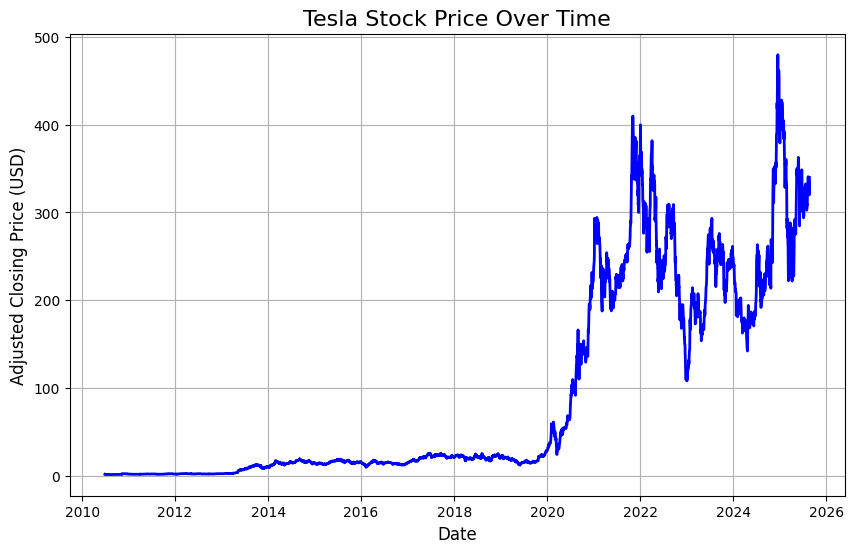

In [22]:
import pandas as pd

# Load Tesla stock data
tesla_stock = pd.read_csv("TSLA_stock.csv")
tesla_stock['Date'] = pd.to_datetime(tesla_stock['Date'])

# Plot Tesla stock
make_graph(tesla_stock, "Tesla Stock Price Over Time")

### GameStop Stock Graph

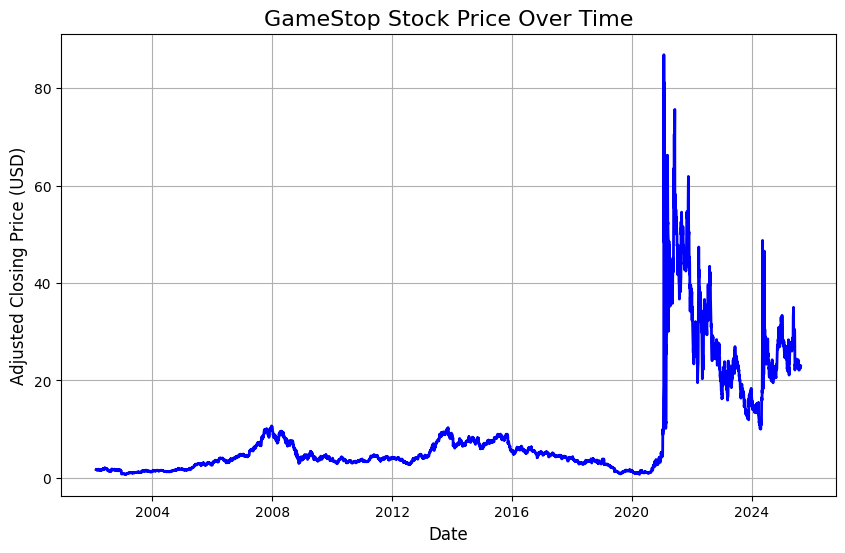

In [23]:
# Load GameStop stock data
gamestop_stock = pd.read_csv("GME_stock.csv")
gamestop_stock['Date'] = pd.to_datetime(gamestop_stock['Date'])

# Plot GameStop stock
make_graph(gamestop_stock, "GameStop Stock Price Over Time")